In [1]:
import os
os.environ['J_NOTEBOOK'] = '1'

from preprocess.preprocess import *
import PARAMETERS
import sys
sys.path.append('./preprocess/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline


PARAMETERS.PREPROCESS_OPTIMIZATION = True

PARAMETERS.LBP_METHOD = 'riu'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'STARE'

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

,LBP_METHOD,METHOD,INTERPOLATION_ALGORITHM,BALANCE,N_SCALES,GRAY_INTENSITY,X2SCALE
Parameters,riu,get_pyramid_dataset,lanczos,False,5,True,True


In [2]:
# Get CV folds

import pandas as pd
import numpy as np

preprocess = Preprocess(
    lbp_radius=1,
    lbp_method=PARAMETERS.LBP_METHOD,
    height={'DRIVE': 608, 'CHASE': 960, 'STARE': 608}[PARAMETERS.DATASET],
    width={'DRIVE': 576, 'CHASE': 1024, 'STARE': 704}[PARAMETERS.DATASET],
    balance=PARAMETERS.BALANCE
)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:14]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)
    
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

cv_folds = {}

for i, j in enumerate(range(0, 14, 3)):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+2, 13)][1])

In [3]:
import pandas as pd

df_train = pd.DataFrame()
df_test = pd.DataFrame()

#for conf in ['_blue', '_blue_lbp_gb', '_green', '_green_lbp_gb']:
for conf in ['_green_lbp_g', '_green_lbp_g_cv']:

    df_train_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_riu = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_riu_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_train_riu.columns]
    df_test_riu.columns = [c + '_riu' if c not in ['Original', 'label'] else c for c in df_test_riu.columns]

    if df_train.shape[0] == 0:
        y_train = df_train_riu['label']
        y_test = df_test_riu['label']
    df_train_riu = df_train_riu.drop(['label'], axis=1)
    df_test_riu = df_test_riu.drop(['label'], axis=1)


    df_train_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_train_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')
    df_test_var = pd.read_pickle(f'../DB/{PARAMETERS.DATASET}/extra_features/preprocess_optimization{conf}/train_test_var_get_pyramid_dataset_lanczos_balance-False_scales-5_x2-True_gray-intensity-True.pkl', compression='gzip')

    df_train_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_train_var.columns]
    df_test_var.columns = [c + '_var' if c not in ['Original', 'label'] else c for c in df_test_var.columns]

    df_train_var = df_train_var.drop(['Original', 'label'], axis=1)
    df_test_var = df_test_var.drop(['Original', 'label'], axis=1)

    df_train_temp = pd.concat([df_train_riu, df_train_var], axis=1)
    df_test_temp = pd.concat([df_test_riu, df_test_var], axis=1)
    df_train_temp.columns = [c + conf for c in df_train_temp.columns]
    df_test_temp.columns = [c + conf for c in df_test_temp.columns]

    if df_train.shape[0] > 0:
        df_train_temp.index = df_train.index
        df_test_temp.index = df_test.index
    df_train = pd.concat([df_train, df_train_temp], axis=1)
    df_test = pd.concat([df_test, df_test_temp], axis=1)
    
display(df_train)
display(df_test)

,Original_green_lbp_g,1:1_riu_green_lbp_g,1:2_riu_green_lbp_g,1:4_riu_green_lbp_g,1:8_riu_green_lbp_g,2:1_1_riu_green_lbp_g,2:1_2_riu_green_lbp_g,2:1_3_riu_green_lbp_g,2:1_4_riu_green_lbp_g,1:1_var_green_lbp_g,...,2:1_3_riu_green_lbp_g_cv,2:1_4_riu_green_lbp_g_cv,1:1_var_green_lbp_g_cv,1:2_var_green_lbp_g_cv,1:4_var_green_lbp_g_cv,1:8_var_green_lbp_g_cv,2:1_1_var_green_lbp_g_cv,2:1_2_var_green_lbp_g_cv,2:1_3_var_green_lbp_g_cv,2:1_4_var_green_lbp_g_cv
0,2.0,1.0,34.0,8.0,4.0,1.0,9.0,8.0,16.0,13.319445,...,8.0,16.0,68.557174,328.355697,2433.192158,1081.113380,12.0,8.0,21.0,18.0
1,2.0,9.0,34.0,8.0,4.0,9.0,9.0,8.0,34.0,15.734363,...,8.0,8.0,64.932746,328.355697,2433.192158,1081.113380,9.0,10.0,21.0,21.0
2,2.0,1.0,33.0,8.0,4.0,1.0,9.0,35.0,27.0,17.688118,...,16.0,16.0,70.279294,298.691129,2433.192158,1081.113380,10.0,10.0,22.0,24.0
3,2.0,1.0,33.0,8.0,4.0,9.0,11.0,35.0,35.0,17.953630,...,16.0,8.0,72.240974,298.691129,2433.192158,1081.113380,12.0,12.0,24.0,27.0
4,2.0,1.0,34.0,8.0,4.0,9.0,9.0,8.0,16.0,15.904023,...,16.0,8.0,74.225196,232.388122,2266.972797,1081.113380,6.0,6.0,25.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311427,2.0,15.0,34.0,34.0,4.0,8.0,8.0,8.0,16.0,1.275444,...,16.0,8.0,42.543538,622.659956,690.891230,1233.793708,4.0,4.0,2.0,3.0
311428,2.0,9.0,34.0,34.0,4.0,8.0,8.0,16.0,8.0,0.662995,...,16.0,16.0,91.904924,341.380469,690.891230,1233.793708,4.0,4.0,2.0,2.0
311429,2.0,0.0,34.0,33.0,8.0,2.0,16.0,4.0,16.0,6.923911,...,2.0,16.0,49.632123,629.225623,1166.895211,1077.785695,6.0,5.0,4.0,2.0
311430,2.0,1.0,34.0,33.0,8.0,8.0,8.0,16.0,8.0,11.219486,...,16.0,8.0,42.430293,629.225623,1166.895211,1077.785695,4.0,3.0,2.0,2.0


,Original_green_lbp_g,1:1_riu_green_lbp_g,1:2_riu_green_lbp_g,1:4_riu_green_lbp_g,1:8_riu_green_lbp_g,2:1_1_riu_green_lbp_g,2:1_2_riu_green_lbp_g,2:1_3_riu_green_lbp_g,2:1_4_riu_green_lbp_g,1:1_var_green_lbp_g,...,2:1_3_riu_green_lbp_g_cv,2:1_4_riu_green_lbp_g_cv,1:1_var_green_lbp_g_cv,1:2_var_green_lbp_g_cv,1:4_var_green_lbp_g_cv,1:8_var_green_lbp_g_cv,2:1_1_var_green_lbp_g_cv,2:1_2_var_green_lbp_g_cv,2:1_3_var_green_lbp_g_cv,2:1_4_var_green_lbp_g_cv
0,2.0,1.0,34.0,8.0,4.0,0.0,1.0,24.0,34.0,28.860241,...,16.0,16.0,58.942036,1502.338482,2572.592657,1684.958301,9.0,8.0,23.0,18.0
1,2.0,27.0,34.0,8.0,4.0,1.0,0.0,21.0,8.0,80.331802,...,8.0,4.0,123.347529,580.500165,1892.815519,1660.565032,21.0,27.0,55.0,58.0
2,2.0,4.0,27.0,8.0,4.0,9.0,9.0,34.0,35.0,96.012170,...,16.0,8.0,150.962877,1017.141171,2417.953918,1660.565032,17.0,18.0,22.0,19.0
3,2.0,8.0,27.0,8.0,4.0,1.0,9.0,34.0,35.0,133.257429,...,8.0,16.0,159.979036,1017.141171,2417.953918,1660.565032,20.0,19.0,25.0,25.0
4,2.0,27.0,35.0,8.0,4.0,1.0,9.0,35.0,34.0,140.700696,...,8.0,16.0,177.321498,1324.120322,2417.953918,1660.565032,18.0,16.0,23.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312886,2.0,16.0,33.0,4.0,8.0,16.0,16.0,34.0,35.0,17.781339,...,8.0,16.0,36.280280,1009.090485,1708.169227,1481.825452,10.0,10.0,8.0,7.0
312887,2.0,8.0,33.0,4.0,8.0,16.0,16.0,35.0,35.0,23.727390,...,16.0,8.0,37.085036,1009.090485,1708.169227,1481.825452,9.0,8.0,6.0,7.0
312888,2.0,4.0,34.0,4.0,8.0,16.0,16.0,35.0,35.0,23.245196,...,16.0,8.0,36.138331,909.241156,1708.169227,1481.825452,9.0,8.0,8.0,8.0
312889,2.0,8.0,34.0,4.0,8.0,16.0,16.0,35.0,34.0,21.953441,...,16.0,8.0,31.115116,909.241156,1708.169227,1481.825452,9.0,11.0,8.0,8.0


In [4]:
# CV

from main import init_clf_and_fit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def cross_validate_features(features, verbose=True):
    f1_list = []
    acc_list = []
    if isinstance(features['y_train'], pd.Series):
        features['y_train'] = features['y_train'].to_frame()
    for k, v in cv_folds.items():
        df_train_temp = pd.concat(
            [features['x_train'].iloc[cv_folds[0][0]:v[0], :],
             features['x_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat(
            [features['y_train'].iloc[cv_folds[0][0]:v[0], :],
             features['y_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(df_train_temp, y_train_temp.values.ravel(), lgb='Num')
        y_predicted = clf.predict(features['x_train'].iloc[v[0]:v[1], :])
        acc = accuracy_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        mat = confusion_matrix(features['y_train'].iloc[v[0]:v[1], :], y_predicted).ravel()
        if verbose:
            print('Accuracy score: ' + str(acc) + '\n')
            print('F1 score: ' + str(f1) + '\n')
            print('Confusion matrix:\n')
            print_confusion_matrix(features['y_train'].iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
            print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
            print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
            print('-------------------------------------')

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}


cross_validate_features({'x_train': df_train, 'y_train':y_train})

Accuracy score: 0.9306787196934339

F1 score: 0.5782202409575921

Confusion matrix:

     t/p    0.0   1.0 
      0.0 826911 22050 
      1.0 42856 44490 
Sensivity: 0.5093536052022989
Specificity: 0.9740270754486955
-------------------------------------
Accuracy score: 0.9269104094587995

F1 score: 0.5811671687643634

Confusion matrix:

     t/p    0.0   1.0 
      0.0 843335 20015 
      1.0 50333 48807 
Sensivity: 0.49230381278999397
Specificity: 0.9768170498639023
-------------------------------------
Accuracy score: 0.9458786889728122

F1 score: 0.7361883342704233

Confusion matrix:

     t/p    0.0   1.0 
      0.0 814925 22515 
      1.0 28159 70705 
Sensivity: 0.7151743809677942
Specificity: 0.9731144917844861
-------------------------------------
Accuracy score: 0.9472699990922246

F1 score: 0.7369553867300295

Confusion matrix:

     t/p    0.0   1.0 
      0.0 817817 21550 
      1.0 27824 69164 
Sensivity: 0.7131191487606714
Specificity: 0.9743258908201061
-----------------

{'acc': 0.9385065705597837, 'f1': 0.6730118166097145}

In [5]:
import pickle
from os import listdir

PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/images'
MASK_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/mask'
LABELS_PATH = fr'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/{PARAMETERS.DATASET}/training/1st_manual'

def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][:14]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][:14]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES = load_images()
MASKS = load_masks()

with open(r'/home/fer/Drive/Estudios/Master-IA/TFM/lbp-pyramid/convolution/outputs/16558520630879009_stare/population.pkl', 'rb') as f:
    kernels = pickle.load(f)
    
population, fitness = kernels['population'], kernels['fitness']
individual = population[np.argmax(fitness), :]
n_kernels = 6
k_size = (3, 5, 7)

features = [pd.DataFrame()]*14
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES, MASKS, features)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features = pd.concat(features, ignore_index=True)

conv_features.index = df_train.index

In [6]:
cross_validate_features({
    'x_train': pd.concat([df_train, conv_features], axis=1),
    'y_train': y_train,
})

Accuracy score: 0.939137483752658

F1 score: 0.6375720264065025

Confusion matrix:

     t/p    0.0   1.0 
      0.0 829197 19764 
      1.0 37222 50124 
Sensivity: 0.5738557003182745
Specificity: 0.9767197786470757
-------------------------------------
Accuracy score: 0.9262631300065455

F1 score: 0.5818865212294024

Confusion matrix:

     t/p    0.0   1.0 
      0.0 842134 21216 
      1.0 49755 49385 
Sensivity: 0.498133951987089
Specificity: 0.9754259570278566
-------------------------------------
Accuracy score: 0.9545478818845161

F1 score: 0.7852381168657493

Confusion matrix:

     t/p    0.0   1.0 
      0.0 815946 21494 
      1.0 21063 77801 
Sensivity: 0.786949749150348
Specificity: 0.9743336836071838
-------------------------------------
Accuracy score: 0.9486957403976056

F1 score: 0.7668270047518966

Confusion matrix:

     t/p    0.0   1.0 
      0.0 809324 30043 
      1.0 17996 78992 
Sensivity: 0.8144512723223492
Specificity: 0.9642075516430835
---------------------

{'acc': 0.9442301359797434, 'f1': 0.7110618065652297}

In [7]:
def load_images_test():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][14:]
    return [np.asarray(Image.open(path).convert('RGB'))[:, :, 1] for path in paths]

def load_masks_test():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][14:]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES_test = load_images_test()
MASKS_test = load_masks_test()

features_test = [pd.DataFrame()]*14
count = 0
for j, ks in enumerate(k_size):
    k_len = int(ks**2)
    features_test = [
        pd.concat([feat_df, pd.DataFrame(np.array(
            [cv2.filter2D(img, -1, individual[(count + i*k_len):(count + (i + 1) * k_len)].reshape((ks, ks)))[mask]
             for i in range(n_kernels // len(k_size))]
        ).T, columns=np.arange(j * (n_kernels // len(k_size)), (j + 1) * (n_kernels // len(k_size))))], axis=1)
        for img, mask, feat_df in zip(IMAGES_test, MASKS_test, features_test)
    ]
    count += k_len * (n_kernels // len(k_size))
    
conv_features_test = pd.concat(features_test, ignore_index=True)
conv_features_test.index = df_test.index

Columns: Index([    'Original_green_lbp_g',      '1:1_riu_green_lbp_g',
            '1:2_riu_green_lbp_g',      '1:4_riu_green_lbp_g',
            '1:8_riu_green_lbp_g',    '2:1_1_riu_green_lbp_g',
          '2:1_2_riu_green_lbp_g',    '2:1_3_riu_green_lbp_g',
          '2:1_4_riu_green_lbp_g',      '1:1_var_green_lbp_g',
            '1:2_var_green_lbp_g',      '1:4_var_green_lbp_g',
            '1:8_var_green_lbp_g',    '2:1_1_var_green_lbp_g',
          '2:1_2_var_green_lbp_g',    '2:1_3_var_green_lbp_g',
          '2:1_4_var_green_lbp_g',  'Original_green_lbp_g_cv',
         '1:1_riu_green_lbp_g_cv',   '1:2_riu_green_lbp_g_cv',
         '1:4_riu_green_lbp_g_cv',   '1:8_riu_green_lbp_g_cv',
       '2:1_1_riu_green_lbp_g_cv', '2:1_2_riu_green_lbp_g_cv',
       '2:1_3_riu_green_lbp_g_cv', '2:1_4_riu_green_lbp_g_cv',
         '1:1_var_green_lbp_g_cv',   '1:2_var_green_lbp_g_cv',
         '1:4_var_green_lbp_g_cv',   '1:8_var_green_lbp_g_cv',
       '2:1_1_var_green_lbp_g_cv', '2:1_2_var_

/home/fer/anaconda3/envs/TFM/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


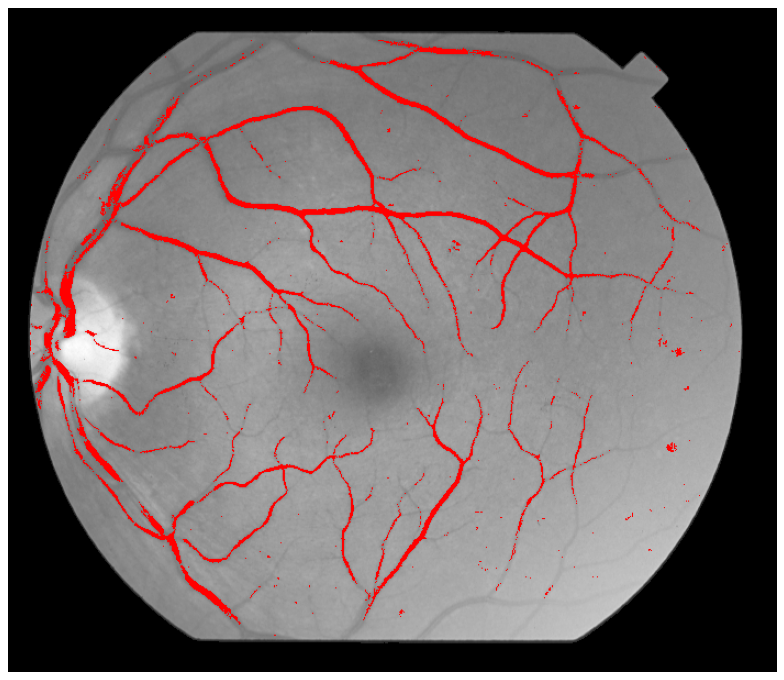

Accuracy score: 0.9422433314440449

F1 score: 0.6207956004180725

Confusion matrix:

     t/p    0.0   1.0 
      0.0 1675339 10986 
      1.0 97132 88500 
Sensivity: 0.4767496983278745
Specificity: 0.9934852415756156


(0.942, 0.621, 1675339, 10986, 97132, 88500)

In [8]:
features = {
    'x_train': pd.concat([df_train, conv_features], axis=1),
    'x_test': pd.concat([df_test, conv_features_test], axis=1),
    'y_train': y_train,
    'y_test': y_test
}

from main import main
PARAMETERS.PLOT = True

main(lgb='Num', features=features, plot_once=True, recurrence=True)